In [74]:
import json
import random

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from pandas import json_normalize


In [192]:
# Read the JSON data
df = pd.read_json('trains.json')

#json_normalize to normalize json data into a table
normalized_df = json_normalize(df['features'])
final_df = pd.concat([df.drop(columns=['features']), normalized_df], axis=1)
len(final_df)

5208

In [77]:
#select the columns that we need, which are the to and from information
final_df = final_df[ ['properties.from_station_code', 'properties.from_station_name', 'properties.to_station_code', 'properties.to_station_name', 'properties.distance']] 

#rename the columns for ease
train_routes = final_df.rename(columns=
                {'properties.from_station_code':'from_code', 
                 'properties.from_station_name':'from_name', 
                 'properties.to_station_code':'to_code', 
                 'properties.to_station_name':'to_name',
                'properties.distance':'distance'})
train_routes

,from_code,from_name,to_code,to_name,distance
0,JAT,JAMMU TAWI,UHP,UDHAMPUR,53.0
1,UHP,UDHAMPUR,JAT,JAMMU TAWI,53.0
2,JAT,JAMMU TAWI,UHP,UDHAMPUR,53.0
3,UHP,UDHAMPUR,JAT,JAMMU TAWI,53.0
4,BDTS,MUMBAI BANDRA TERMINUS,BKN,BIKANER JN,1212.0
...,...,...,...,...,...
5203,NDLS,NEW DELHI,PWL,PALWAL,56.0
5204,VSKP,VISHAKAPATNAM,RJY,RAJAMUNDRY,201.0
5205,MAO,MADGAON,KAWR,KARWAR,82.0
5206,DNR,DANAPUR,GRD,Giridih,298.0


In [178]:
#number of outgoing trains at each station
outgoing = train_routes.groupby('from_code').size().reset_index(name='outgoing_trains')

#number of incoming trains at each station
incoming = train_routes.groupby('to_code').size().reset_index(name='incoming_trains')

#merge in and out data
routes = pd.merge(outgoing, incoming, left_on='from_code', right_on='to_code', how='outer')
routes = routes.dropna()
routes['total_traffic'] = routes['outgoing_trains'] + routes['incoming_trains']
routes

,from_code,outgoing_trains,to_code,incoming_trains,total_traffic
0,ABKP,4.0,ABKP,4.0,8.0
1,ABS,1.0,ABS,1.0,2.0
2,ADB,4.0,ADB,4.0,8.0
3,ADI,55.0,ADI,57.0,112.0
5,ADRA,4.0,ADRA,4.0,8.0
...,...,...,...,...,...
719,WGI,4.0,WGI,3.0,7.0
720,WR,4.0,WR,3.0,7.0
721,WSA,1.0,WSA,1.0,2.0
722,YPR,39.0,YPR,39.0,78.0


In [172]:
G = nx.DiGraph()

# Add edges to the graph
for _, row in train_routes.iterrows():
    G.add_edge(row['from_code'], row['to_code'], weight=row['distance'])

#remove any self edges
G.remove_edges_from(nx.selfloop_edges(G))


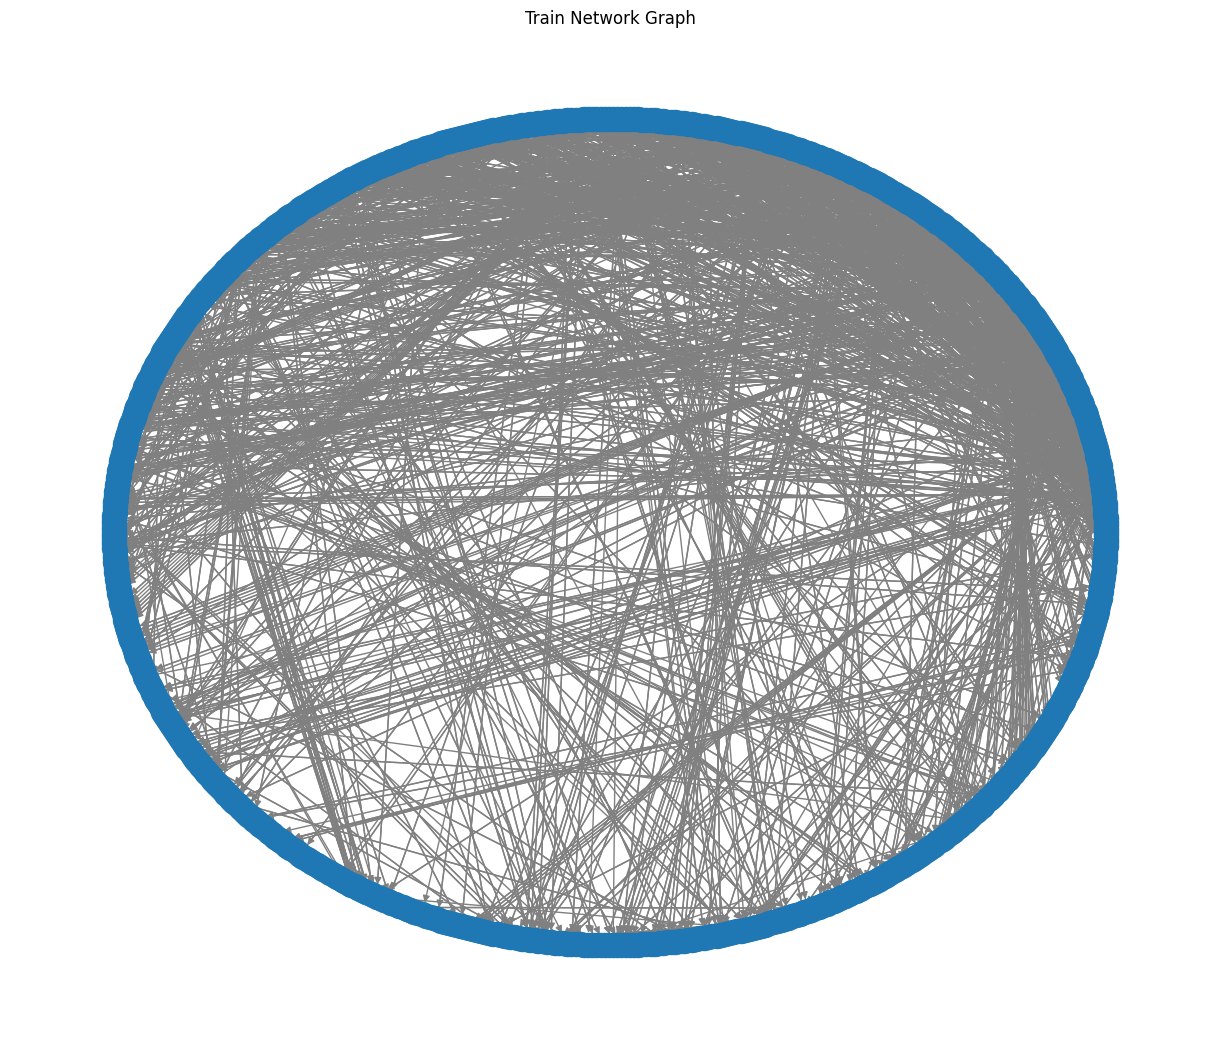

In [191]:
plt.figure(figsize=(12, 10))

pos = nx.circular_layout(G) 

nx.draw(G, pos, with_labels=False,edge_color='gray')

plt.title('Train Network Graph')

plt.show()

In [173]:
#filter the train routes so we only have the routes with important stations
top_outgoing_stations = outgoing.sort_values(by='outgoing_trains', ascending=False)[0:50]
top_stations = top_outgoing_stations['from_code'].tolist()

filtered_routes = train_routes[train_routes['from_code'].isin(top_stations) & 
                               train_routes['to_code'].isin(top_stations)]
filtered_routes

,from_code,from_name,to_code,to_name,distance
9,JAT,JAMMU TAWI,BDTS,MUMBAI BANDRA TERMINUS,1957.0
11,CSTM,MUMBAI CST,BBS,BHUBANESWAR,1932.0
12,BBS,BHUBANESWAR,CSTM,MUMBAI CST,1932.0
17,CSTM,MUMBAI CST,MAS,CHENNAI CENTRAL,1283.0
20,PUNE,PUNE JN,DBG,DARBHANGA JN,1948.0
...,...,...,...,...,...
5147,BSB,VARANASI JN,ASN,ASANSOL JN,489.0
5153,DHN,DHANBAD JN,RNC,RANCHI,162.0
5191,ADI,AHMEDABAD JN,BCT,Mumbai Central,491.0
5195,PNBE,PATNA JN,GAYA,GAYA JN,92.0


In [181]:
G_top_50 = nx.DiGraph()
for _, row in filtered_routes.iterrows():
    G_top_50.add_edge(row['from_code'], row['to_code'])


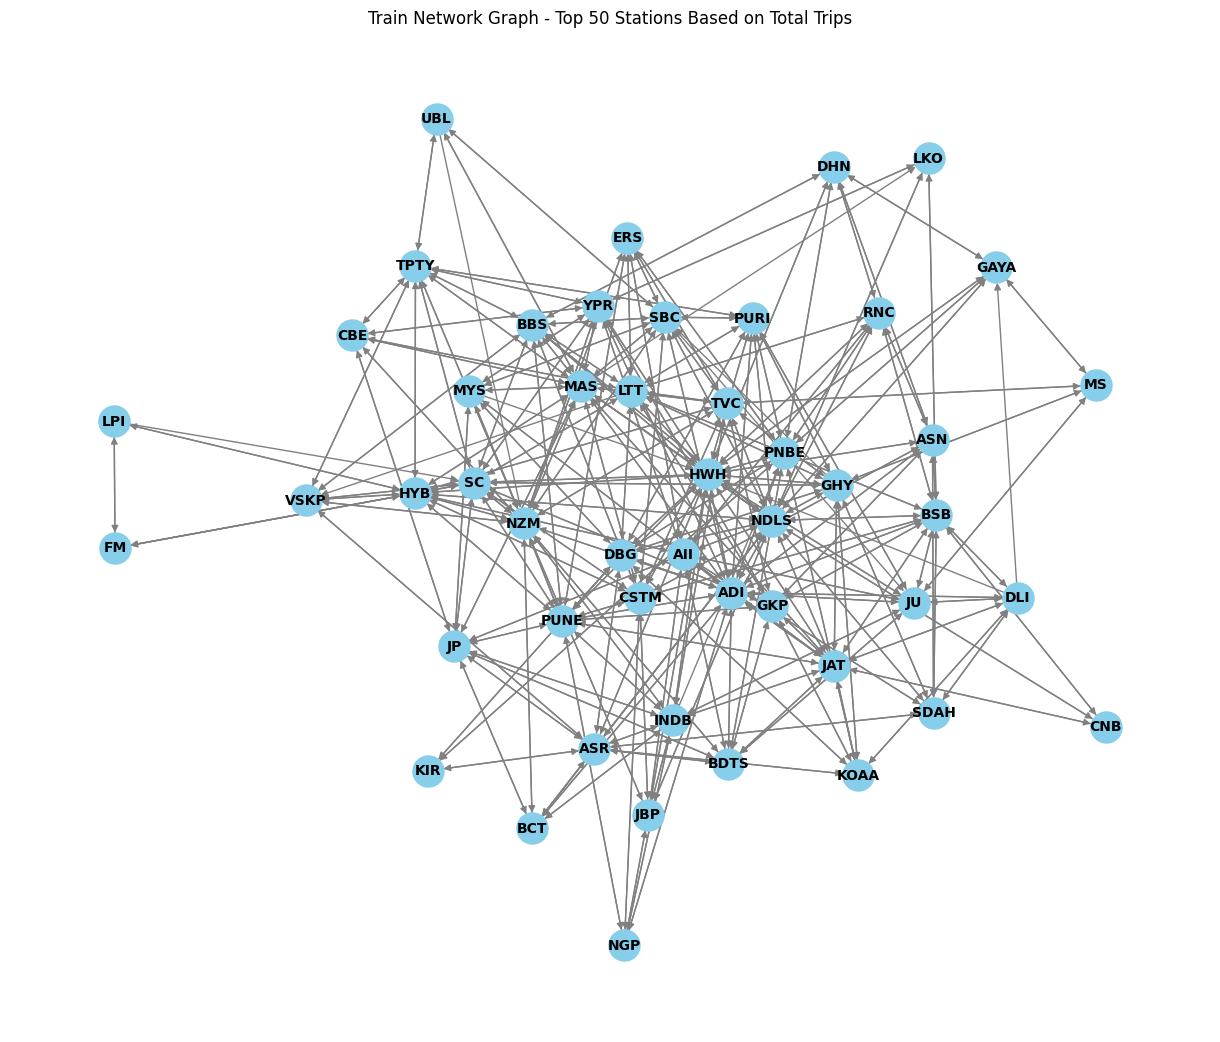

In [190]:
#plot the top 50
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_top_50)  
nx.draw(G_top_50, pos, with_labels=True, node_size=500, font_size=10, font_weight='bold', node_color='skyblue', edge_color='gray')
plt.title('Train Network Graph - Top 50 Stations Based on Total Trips')
plt.show()